# Parallel filtering and smoothing in an LG-SSM

This notebook shows how can reduce the cost of inference from linear to logarithmic in time, if
we have a GPU device. Rather than running a Kalman filter/smoother sequentially in time, you can use a **parallel (associative) scan** to compute the filtering and smoothing distributions using a parallel algorithm that requires $O(T)$ parallel processors, but can run in only $O(\log T)$ time. This is the key innovation behind modern "deep" state space models like S5 (Smith et al., 2023) and Mamba (Gu and Dao, 2024). The core algorithm is nicely described by Särkkä and Garćıa-Ferńandez (2020). 

This notebook is adapted from an [example notebook](https://github.com/EEA-sensors/sequential-parallelization-examples/blob/main/python/temporal-parallelization-bayes-smoothers/parallel_kalman_jax.ipynb) by [Adrien Correnflos](https://github.com/AdrienCorenflos). Some small changes have been made so it works with dynamax.

If you have a GPU, you should be able to get a speedup curve like this:

![Parallel KF](https://github.com/probml/dynamax/blob/main/docs/figures/lgssm_parallel_smoothing_timing.png?raw=true)

Similar algorithms exist for HMMs (Hassan et al., 2021), which we have implemented in [`dynamax.hidden_markov_model.parallel_inference`](https://probml.github.io/dynamax/api.html#dynamax.hidden_markov_model.parallel_hmm_filter)

## References
- Särkkä, Simo, and Ángel F. García-Fernández. "Temporal parallelization of Bayesian smoothers." IEEE Transactions on Automatic Control 66.1 (2020): 299-306.
- Smith, Jimmy TH, Andrew Warrington, and Scott Linderman. "Simplified State Space Layers for Sequence Modeling." The Eleventh International Conference on Learning Representations.
- Gu, Albert, and Tri Dao. "Mamba: Linear-time sequence modeling with selective state spaces." arXiv preprint arXiv:2312.00752 (2023).
- Hassan, Syeda Sakira, Simo Särkkä, and Ángel F. García-Fernández. "Temporal parallelization of inference in hidden Markov models." IEEE Transactions on Signal Processing 69 (2021): 4875-4887.


## Setup

In [1]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [2]:
import jax
from jax import numpy as jnp
from jax import random as jr
from jax import block_until_ready
from matplotlib import pyplot as plt
import time

from dynamax.linear_gaussian_ssm import lgssm_smoother, parallel_lgssm_smoother
from dynamax.linear_gaussian_ssm import LinearGaussianSSM

In [3]:
print(jax.devices())
print(jax.devices()[0].platform)
if jax.devices()[0].platform == 'cpu':
    cpu_mode = True
else:
    cpu_mode = False
    

[CpuDevice(id=0)]
cpu


## Model

The model is a simple tracking model (see Example 3.6 in *Bayesian Filtering and Smoothing* (S. Särkkä, 2013).


In [4]:
dt = 0.1
F = jnp.eye(4) + dt * jnp.eye(4, k=2)
Q = 1. * jnp.kron(jnp.array([[dt**3/3, dt**2/2],
                      [dt**2/2, dt]]), 
                 jnp.eye(2))
H = jnp.eye(2, 4)
R = 0.5 ** 2 * jnp.eye(2)
μ0 = jnp.array([0.,0.,1.,-1.])
Σ0 = jnp.eye(4)

In [5]:
latent_dim = 4
observation_dim = 2
input_dim = 0

lgssm = LinearGaussianSSM(latent_dim, observation_dim)
params, _ = lgssm.initialize(
    initial_mean=μ0,
    initial_covariance= Σ0,
    dynamics_weights=F,
    dynamics_covariance=Q,
    emission_weights=H,
    emission_covariance=R)



## Test parallel inference on a single sequence

In [6]:
num_timesteps = 100
key = jr.PRNGKey(0)

key, subkey = jr.split(key)
z,emissions = lgssm.sample(params, subkey, num_timesteps)
ssm_posterior = lgssm_smoother(params, emissions)
parallel_posterior = parallel_lgssm_smoother(params, emissions)

print(parallel_posterior.filtered_means.shape)
print(parallel_posterior.filtered_covariances.shape)


(100, 4)
(100, 4, 4)


In [7]:

assert jnp.allclose(parallel_posterior.filtered_means, ssm_posterior.filtered_means, atol=1e-3)
assert jnp.allclose(parallel_posterior.filtered_covariances, ssm_posterior.filtered_covariances, atol=1e-3)


assert jnp.allclose(parallel_posterior.smoothed_means, ssm_posterior.smoothed_means, atol=1e-3)
assert jnp.allclose(parallel_posterior.smoothed_covariances, ssm_posterior.smoothed_covariances, atol=1e-3)

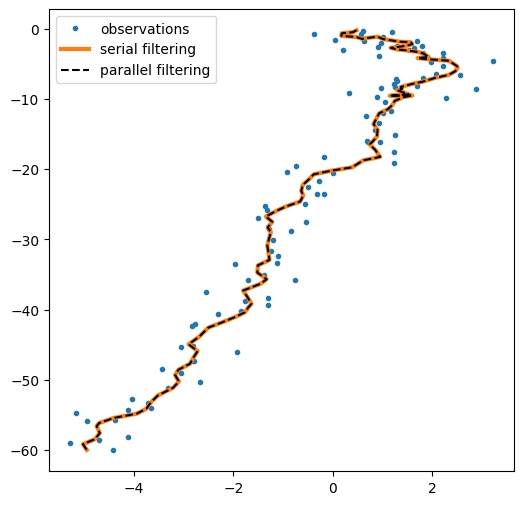

In [8]:
plt.figure(figsize=(6,6))
plt.plot(*emissions.T,'.', label="observations")
plt.plot(*ssm_posterior.filtered_means[:,:2].T, label="serial filtering", lw=3)
plt.plot(*parallel_posterior.filtered_means[:,:2].T, "--k", label="parallel filtering");
plt.legend();

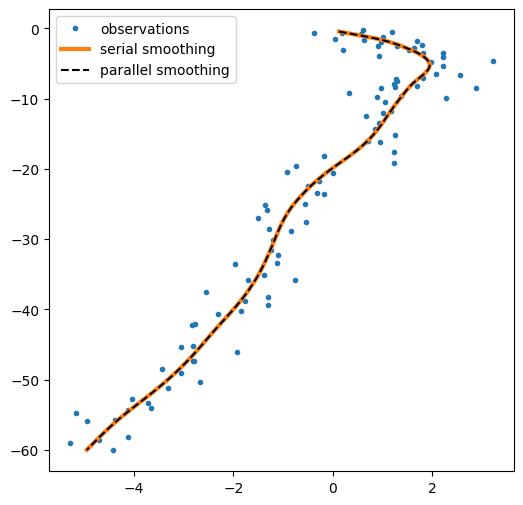

In [9]:
plt.figure(figsize=(6,6))
plt.plot(*emissions.T,'.', label="observations")
plt.plot(*ssm_posterior.smoothed_means[:,:2].T, lw=3,label="serial smoothing")
plt.plot(*parallel_posterior.smoothed_means[:,:2].T, "--k", label="parallel smoothing")
plt.legend();


## Timing comparison

In [10]:
key = jr.PRNGKey(0)
if cpu_mode:
    Ts = [100, 200, 500]
    num_repeats = 1
else:
    Ts = [100, 1_000, 10_000, 100_000]
    num_repeats = 3
serial_smoothing_durations = []
parallel_smoothing_durations = []
compiled = False

for T in Ts:
    
    key, subkey = jr.split(key)
    z,emissions = lgssm.sample(params, subkey, T)

    if not compiled:
        ssm_posterior = block_until_ready(lgssm_smoother(params, emissions))
        parallel_posterior = block_until_ready(parallel_lgssm_smoother(params, emissions))
    
    start = time.time()
    for _ in range(num_repeats):
        ssm_posterior = block_until_ready(lgssm_smoother(params, emissions))
    end = time.time()
    mean_time = (end-start)/num_repeats
    serial_smoothing_durations.append(mean_time)
    print(f"Num timesteps={T}, \t time serial = {mean_time}")
    
    start = time.time()
    for _ in range(num_repeats):
        parallel_posterior = block_until_ready(parallel_lgssm_smoother(params, emissions))
    end = time.time()
    mean_time = (end-start)/num_repeats
    parallel_smoothing_durations.append(mean_time)
    print(f"Num timesteps={T}, \t time parallel = {mean_time}")

Num timesteps=100, 	 time serial = 0.12801480293273926
Num timesteps=100, 	 time parallel = 0.07607126235961914
Num timesteps=200, 	 time serial = 0.12250518798828125
Num timesteps=200, 	 time parallel = 0.08577895164489746
Num timesteps=500, 	 time serial = 0.12784910202026367
Num timesteps=500, 	 time parallel = 0.09820008277893066


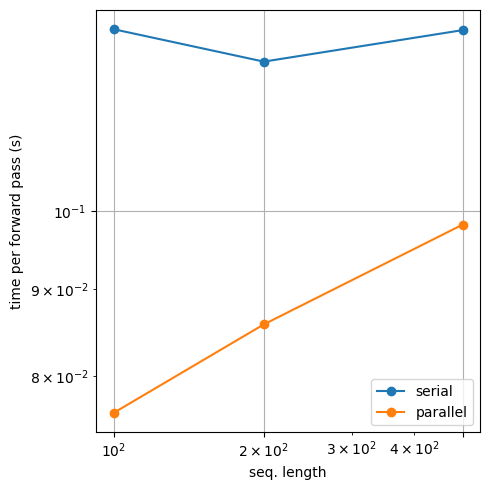

In [11]:
plt.figure(figsize=(5, 5))
plt.loglog(Ts, serial_smoothing_durations, '-o', label='serial')
plt.loglog(Ts, parallel_smoothing_durations, '-o', label='parallel')
plt.xticks(Ts)
plt.xlabel("seq. length")
plt.ylabel("time per forward pass (s)")
plt.grid(True)
plt.legend()
plt.tight_layout()